In [1]:
# read .xlsx file from downloads folderL 
import pandas as pd
df = pd.read_excel('/Users/shaik/Downloads/Performance_Dubai_BTCUSD.xlsx', sheet_name='Sheet1')
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date", drop=False)

In [2]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT"]
timeframes = ["1d"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2023-01-01 00:00:00",
                                        limit = 1000, update=False)


Getting <<BTC-USDT>> from <<kucoin>> 
BTC-USDT (1d)


In [3]:
df =pd.merge(df, klines_dict["ccxt_kucoin__BTC-USDT"]["1d"][["close","volume"]], left_index=True, right_index=True, how="left")
df

,Date,PV,close,volume
Date,,,,
2023-04-24,2023-04-24,400146.75,27506.0,4616.001503
2023-04-25,2023-04-25,400209.24,28297.0,4577.010334
2023-04-26,2023-04-26,400397.08,28415.1,9392.808779
2023-04-27,2023-04-27,397767.00,29473.9,7447.575043
2023-04-28,2023-04-28,400000.31,29309.9,4842.034658
...,...,...,...,...
2023-09-18,2023-09-18,423483.36,26764.1,3299.246038
2023-09-19,2023-09-19,420423.90,27204.2,3083.837233
2023-09-20,2023-09-20,413148.65,27120.2,2540.666833


      Month Return                              
Month            4     5     6     7     8     9
Year                                            
2023           NaN  1.13 -0.41  5.64 -0.41  0.85



df_pivot:
      Month Return                              
Month            4     5     6     7     8     9
Year                                            
2023           NaN  1.13 -0.41  5.64 -0.41  0.85


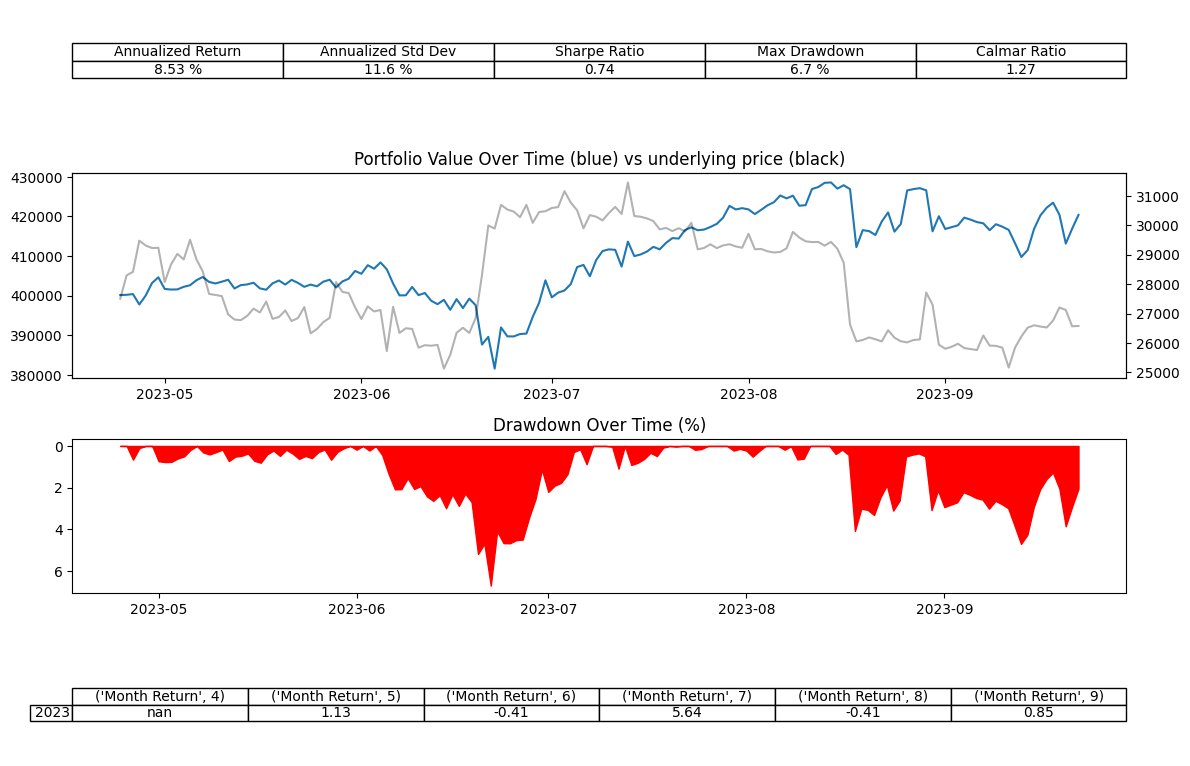

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def calculate_metrics(df0):
    # Ensure the Date column is in datetime format
    df=df0.copy()
    # Calculate daily returns
    df['Return'] = df['PV'].pct_change()
    
    # Calculate annualized return
    annualized_return = np.prod(1 + df['Return']) ** (252/len(df)) - 1
    
    # Calculate annualized standard deviation
    annualized_std_dev = df['Return'].std() * np.sqrt(252)
    
    # Calculate Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_std_dev
    
    # Calculate maximum drawdown
    df['Cumulative Return'] = (1 + df['Return']).cumprod()
    df['Cumulative Roll Max'] = df['Cumulative Return'].cummax()
    df['Drawdown'] = df['Cumulative Roll Max'] - df['Cumulative Return']
    max_drawdown = df['Drawdown'].max()
    
    # Calculate Calmar ratio
    calmar_ratio = annualized_return / max_drawdown
    
    metrics = {'Annualized Return': f"{round(annualized_return*100, 2)} %",
               'Annualized Std Dev': f"{round(annualized_std_dev*100, 2)} %",
               'Sharpe Ratio': round(sharpe_ratio, 2),
               'Max Drawdown': f"{round(max_drawdown*100, 2)} %",
               'Calmar Ratio': round(calmar_ratio, 2)}
    
    # Plotting
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2, 1.5, 1]})
    
    ax[0].axis('tight')
    ax[0].axis('off')
    ax[0].table(cellText=[list(metrics.values())], colLabels=list(metrics.keys()), cellLoc='center', loc='center')
    
    ax[1].plot(df.index, df['PV'], label='PV')
    ax1_twin = ax[1].twinx()
    ax1_twin.plot(df.index, df['close'], color='black', label='Close', alpha=0.3)
    ax[1].set_title('Portfolio Value Over Time (blue) vs underlying price (black)')
    
    ax[2].fill_between(df.index, df['Drawdown']*100, color='red')
    ax[2].set_title('Drawdown Over Time (%)')
    ax[2].invert_yaxis()
    
    plt.tight_layout()
    

    # Calculate monthly returns and display as a table below the drawdown plot
    df_m = pd.DataFrame()
    monthly_returns = df.resample('M')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    # Round to 2 dp
    monthly_returns = monthly_returns.round(2)
    df_m["Month Return"] = monthly_returns
    # monthly_returns = df1.resample('M')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    

    
    ax[3].axis('tight')
    ax[3].axis('off')
    
    # cell_text = [[f"{v*100:.2f} %" if pd.notnull(v) else "" for v in monthly_returns.values]] # Reshape to a 2D l}ist and convert to percentage string
    # ax[3].table(cellText=cell_text, rowLabels=[], colLabels=monthly_returns.index.strftime('%Y-%m'), cellLoc='center', loc='center')
    df_m['Month'] = df_m.index.month
    df_m['Year'] = df_m.index.year 
    

    # Pivot the table 
    df_pivot = df_m.pivot(index='Year', columns='Month')

    # Now we can plot the table
    index_months = {0:"Jan", 1:"Feb", 2:"Mar", 3:"Apr", 4:"May", 5:"Jun", 
                6:"Jul", 7:"Aug", 8:"Sep", 9:"Oct", 10:"Nov", 11:"Dec"}
    print(df_pivot)
    cell_text = df_pivot.values.tolist() # Convert DataFrame values to a 2D list
    ax[3].table(cellText=cell_text, rowLabels=df_pivot.index, colLabels=df_pivot.columns, cellLoc='center', loc='center')


    print(f"\n\n\ndf_pivot:\n{df_pivot}")
    return df_pivot

df_pivot = calculate_metrics(df)


In [82]:
df_pivot

Month Return                              
Month            4     5     6     7     8     9
Year                                            
2023           NaN  1.13 -0.41  5.64 -0.41  0.85

('monthly_returns', 5)